<a href="https://colab.research.google.com/github/julialromero/Collaborative-Problem-Solving/blob/main/learning_pipeline_angelina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/julialromero/Collaborative-Problem-Solving/blob/main/learning_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import os
from skimage import io
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras import layers, Input, Model, optimizers
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

PROJECT_DIR = "drive/MyDrive/CSCI 5922 - Final Project/"

Thu Apr 28 20:10:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W /  70W |    270MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get User Input

In [ ]:
# Choose what size images to use
## "small" = 98x98, "med" = 332x332, "large" = 719x719
image_size = "small"
shuffled = False
chance = False
num_iters = 1
num_folds = 10
threshold = 0.5

if image_size == "large":
  imgsize = (int(719/2), int(719/2)) 
  if shuffled:
    IMG_DIR = "719x719 - Recurrence_Matrices/RAW_SHUFFLED/"
  else:
    IMG_DIR = "719x719 - Recurrence_Matrices/RAW/"

elif image_size == "med":
  imgsize = (332, 332)
  if shuffled:
    IMG_DIR = "332x332 - Recurrence_Matrices/RAW_SHUFFLED/"
  else:
    IMG_DIR = "332x332 - Recurrence_Matrices/RAW/"

elif image_size == "small":
  imgsize = (98, 98)
  if shuffled:
    IMG_DIR = "98x98 - Recurrence_Matrices/RAW_SHUFFLED/"
  else:
    IMG_DIR = "98x98 - Recurrence_Matrices/RAW/"

print("Processing images from: ", IMG_DIR)

Processing images from:  98x98 - Recurrence_Matrices/RAW/


# Scratchwork

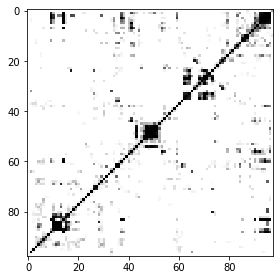

In [ ]:
from skimage import io
imag = io.imread(PROJECT_DIR + IMG_DIR + '1010-ExpBlock1_RAW.png', as_gray=True)
io.imshow(imag)

In [ ]:
for filename in os.listdir(PROJECT_DIR + IMG_DIR)[0:15]:
    imag = io.imread(PROJECT_DIR + IMG_DIR + filename, as_gray=True)
    print(imag.shape)

(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)


(719, 719, 3)


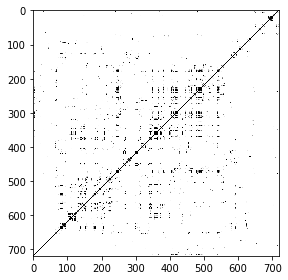

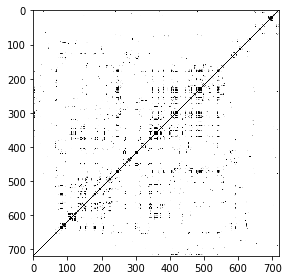

In [ ]:

imag = io.imread(PROJECT_DIR + IMG_DIR + '1020-ExpBlock1_RAW.png', as_gray=True)
plt.figure()
io.imshow(imag)

x = image.img_to_array(imag)
# x = tf.image.resize(x, imgsize) # TODO: try interpolation = "nearest" instead of default "bilinear"

x = np.squeeze(np.stack((x,)*3))
x = x.swapaxes(0,1)
x = x.swapaxes(1,2)
print(x.shape)
plt.figure()
io.imshow(x)



x shape:  (719, 719, 1)


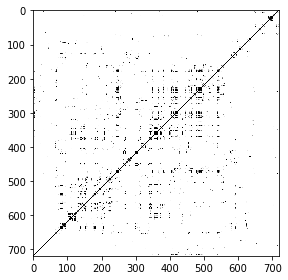

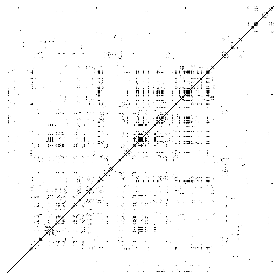

In [ ]:

x = tf.image.resize(x, imgsize) # TODO: try interpolation = "nearest" instead of default "bilinear"

#x = tf.keras.preprocessing.image.smart_resize(x, imgsize)
x = np.array(x)
plt.figure()
plt.axis('off')
io.imshow(x.squeeze())
#n = preprocess_input(x)    # preprocess input for Inception v3
print("x shape: ", x.shape)

# Helper Functions

---NOTE---
Resizing the image changes the RP so for now keep it the same size.

In [ ]:
# read, preprocess, and scale images to uniform dimension

def extract_image(image_path):
    imag = io.imread(image_path, as_gray=True)
    x = image.img_to_array(imag)

    x = tf.image.resize(x, imgsize) # TODO: try interpolation = "nearest" instead of default "bilinear"

    return x

def extract_image_inceptionv3(image_path):
    imag = io.imread(image_path, as_gray=True)
    x = image.img_to_array(imag)

    x = tf.image.resize(x, imgsize) # TODO: try interpolation = "nearest" instead of default "bilinear"
    x = np.squeeze(np.stack((x,)*3))
    x = x.swapaxes(0,1)
    x = x.swapaxes(1,2)

    return x





In [ ]:
def accuracy(predicted, observed):
    if(len(predicted) != len(observed)):
        print("Error - length of input series is not equal.")
        return np.nan
    
    correct = 0
    for pred, obs in zip(predicted, observed):
        if pred == obs:
            correct += 1
    acc = correct / len(predicted)
    return acc

In [ ]:
def extract_score(filename, outcome_df, score_col="task_score"):
    #  match this file's id/block with task score and return
    groupid, splitname = filename.split("-")
    block = splitname.split("_")[0]
    row = outcome_df.loc[(outcome_df.GROUPID == int(groupid)) & (outcome_df.block == block)]
    if(row.shape[0] != 1):
        print(f"Error -- Number of task scores recorded is not 1 for block {block} and groupid {groupid}.")
        return np.nan
    score = row[score_col].values[0]
    return score

In [ ]:
def extract_binary_score(filename, outcome_df, score_col="task_score", median_score=2):
    #  match this file's id/block with task score and return
    groupid, splitname = filename.split("-")
    block = splitname.split("_")[0]
    row = outcome_df.loc[(outcome_df.GROUPID == int(groupid)) & (outcome_df.block == block)]
    if(row.shape[0] != 1):
        print(f"Error -- Number of task scores recorded is not 1 for block {block} and groupid {groupid}.")
        return np.nan
    raw_score = row[score_col].values[0]
    if raw_score <= median_score:
        score = 0
    else:
        score = 1
    return score

In [ ]:

def get_fold_data(GROUPID_list, incv3=False):
  # read data to np arrays
  recurrence_plot_list = []
  if incv3:
    recurrence_plot_list_incv3 = []
  
  labels = []
  binary_labels = []

  for filename in os.listdir(PROJECT_DIR + IMG_DIR):
      # Check if file belongs to one of the teams in the desired group
      for GROUPID in GROUPID_list:
        if str(GROUPID) == filename.split("-")[0]:
          # preprocess image
          t = extract_image(PROJECT_DIR + IMG_DIR + filename)
          if incv3:
            t_incv3 = extract_image_inceptionv3(PROJECT_DIR + IMG_DIR + filename)

          # get task score
          lab = extract_score(filename, outcome_df, score_col="task_score")
          bin_lab = extract_binary_score(filename, outcome_df, score_col="task_score", median_score=2)

          # append data
          recurrence_plot_list.append(t)
          if incv3:
            recurrence_plot_list_incv3.append(t_incv3)
          
          labels.append(lab)
          binary_labels.append(bin_lab)
      
  recurrence_plot_list = np.array(recurrence_plot_list)
  if incv3:
    recurrence_plot_list_incv3 = np.array(recurrence_plot_list_incv3)
    plot_list = recurrence_plot_list_incv3
  else:
    plot_list = recurrence_plot_list
  
  labels = np.array(labels)
  binary_labels = np.array(binary_labels)

  print("\m FOLD DATA INFO: ")
  print(f"\trecurrence_plot_list: {recurrence_plot_list.shape}")
  if incv3:
    print(f"\trecurrence_plot_list_incv3: {recurrence_plot_list_incv3.shape}")
  
  binary_counts = dict(Counter(binary_labels))
  print("\tBinary label counts: ", binary_counts)

  return [plot_list, labels, binary_labels]
  

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Load and preprocess data

In [ ]:
outcome_df = pd.read_csv(PROJECT_DIR + "team_block_outcomes.csv")

# get median task_score
task_scores = outcome_df["task_score"]
median_task_score = np.median(task_scores)
mean_task_score = np.mean(task_scores)
print("median: ", median_task_score)
print("mean: ", mean_task_score)

# score_counts = dict(Counter(task_scores))
# for key in score_counts:
#     print("%d: %d" % (key, score_counts[key]))

outcome_df

median:  2.0
mean:  3.5437956204379564


In [ ]:
# read data to np arrays
recurrence_plot_list = []
recurrence_plot_list_incv3 = []
labels = []
binary_labels = []

for filename in os.listdir(PROJECT_DIR + IMG_DIR):
    # preprocess image
    t = extract_image(PROJECT_DIR + IMG_DIR + filename)
    t_incv3 = extract_image_inceptionv3(PROJECT_DIR + IMG_DIR + filename)

    # get task score
    lab = extract_score(filename, outcome_df, score_col="task_score")
    bin_lab = extract_binary_score(filename, outcome_df, score_col="task_score", median_score=2)

    # append data
    recurrence_plot_list.append(t)
    recurrence_plot_list_incv3.append(t_incv3)
    labels.append(lab)
    binary_labels.append(bin_lab)
    

recurrence_plot_list = np.array(recurrence_plot_list)
recurrence_plot_list_incv3 = np.array(recurrence_plot_list_incv3)
labels = np.array(labels)
binary_labels = np.array(binary_labels)

print(f"recurrence_plot_list: {recurrence_plot_list.shape}")
print(f"recurrence_plot_list_incv3: {recurrence_plot_list_incv3.shape}")
binary_counts = dict(Counter(binary_labels))
print("Binary label counts: ", binary_counts)

print("Continous label ex: ", labels[4])
print("Binary label ex: ", binary_labels[4])


recurrence_plot_list: (271, 98, 98, 1)
recurrence_plot_list_incv3: (271, 98, 98, 3)
Binary label counts:  {1: 132, 0: 139}
Continous label ex:  8.0
Binary label ex:  1


In [ ]:
if (recurrence_plot_list.shape[0] == len(np.unique(recurrence_plot_list, axis=0))):
    print("No duplicate samples.")
else:
    print("WARNING - duplicate samples.")
    

No duplicate samples.


# Binary Classification
Output layer has 1 node with sigmoid activation.
y labels are 0 or 1


## Model from scratch

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

# Split into train/test/val set
# Roughly val - 15%, test - 15%, train - 70%
X_train, X_test, y_train, y_test = train_test_split(recurrence_plot_list, binary_labels, train_size=0.9)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.95)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("\n")
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("\n")
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)
print("\n")

print(y_test)

X_train:  (230, 98, 98, 1)
y_train:  (230,)


X_val:  (13, 98, 98, 1)
y_val:  (13,)


X_test:  (28, 98, 98, 1)
y_test:  (28,)


[0 0 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0]


In [ ]:
# Garcia-Ceja paper feeds CNN images with dims 100 x 100 x 4 (width x height x channels)
# Labels are one hot encoded

inputs = Input(shape=(imgsize[0], imgsize[1], 1))
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(inputs)
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(512, activation="relu")(x) 
x = layers.Dropout(0.50)(x)
x = layers.Flatten()(x)
out = layers.Dense(1, activation="sigmoid")(x)   # change output layer to 1 and activation to sigmoid


bc = tf.keras.losses.BinaryCrossentropy()        # change loss to binary
lr = 0.00001 # paper used 0.001
eps = 1e-08  # paper used 1e-08, but keras default is 1e-07
adam = keras.optimizers.Adam(learning_rate=lr, epsilon=eps)
auc = tf.keras.metrics.AUC(
      num_thresholds=200,
      curve="ROC",
      from_logits=False
)
prec = tf.keras.metrics.Precision()
rec = tf.keras.metrics.Recall()


model_binary = Model(inputs=inputs, outputs=out)
model_binary.compile(
  optimizer=adam,
  loss=bc, 
  metrics=['accuracy', auc, prec, rec],
)

model_binary.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 98, 98, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 96, 96, 16)        160       
                                                                 
 conv2d_21 (Conv2D)          (None, 94, 94, 16)        2320      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 47, 47, 16)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 45, 45, 32)        4640      
                                                          

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# es = EarlyStopping(monitor='val_loss', patience=15)

if shuffled:
  MODEL_SAVE_DIR = PROJECT_DIR + 'results/shuffled/' + '.' + image_size + '_binary_best_weights.hdf5'
else:
  MODEL_SAVE_DIR = PROJECT_DIR + 'results/' + '.' + image_size + '_70a_binary_best_weights.hdf5'

print("Saving model to: ", MODEL_SAVE_DIR)

mcp_save = ModelCheckpoint(MODEL_SAVE_DIR, save_best_only=True, monitor='val_loss', mode='min')

info2 = model_binary.fit(x=X_train, y=y_train, epochs=70, verbose=True, validation_data=(X_val, y_val) ) #, \
                        #  callbacks=[mcp_save])


Saving model to:  drive/MyDrive/CSCI 5922 - Final Project/results/.small_70a_binary_best_weights.hdf5
Epoch 1/70
8/8 [==============================] - 2s 135ms/step - loss: 7.0091 - accuracy: 0.5043 - auc_5: 0.5054 - precision_5: 0.5000 - recall_5: 0.5614 - val_loss: 1.7604 - val_accuracy: 0.3846 - val_auc_5: 0.7875 - val_precision_5: 0.3846 - val_recall_5: 1.0000
Epoch 2/70
8/8 [==============================] - 0s 21ms/step - loss: 6.2512 - accuracy: 0.4957 - auc_5: 0.5150 - precision_5: 0.4898 - recall_5: 0.4211 - val_loss: 2.9609 - val_accuracy: 0.6154 - val_auc_5: 0.5000 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/70
8/8 [==============================] - 0s 22ms/step - loss: 6.7017 - accuracy: 0.4652 - auc_5: 0.4753 - precision_5: 0.4545 - recall_5: 0.3947 - val_loss: 1.9058 - val_accuracy: 0.3846 - val_auc_5: 0.7625 - val_precision_5: 0.3846 - val_recall_5: 1.0000
Epoch 4/70
8/8 [==============================] - 0s 22ms/step - loss: 6.0668 - accuracy: 0.48

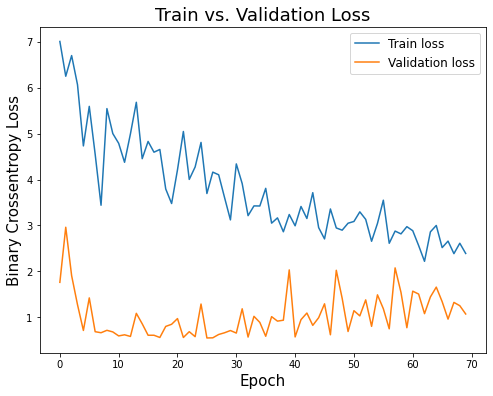

In [ ]:
epochs = [i for i in range(len(info2.history['accuracy']))]
plt.figure(figsize=(8,6))
plt.plot(epochs, info2.history['loss'], label="Train loss")
plt.plot(epochs, info2.history['val_loss'], label="Validation loss")
plt.legend(fontsize=12)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Binary Crossentropy Loss", fontsize=15)
plt.title("Train vs. Validation Loss", fontsize=18)

if shuffled:
  LOSS_SAVE_DIR = PROJECT_DIR + 'results/shuffled/' + image_size + '_binary_loss'
else:
  LOSS_SAVE_DIR = PROJECT_DIR + 'results/' + image_size + '_70a_binary_loss'

plt.savefig(LOSS_SAVE_DIR)

In [ ]:
train_scores = model_binary.evaluate(X_train, y_train, verbose = 0) 

print("===== Train Set Results =====\n")
for metric,val in zip(model_binary.metrics_names, train_scores):
  print("%12s: %.3f" % (metric, val))

===== Train Set Results =====

        loss: 0.632
    accuracy: 0.688
      auc_13: 0.803
precision_13: 0.770
   recall_13: 0.490


In [ ]:
val_scores = model_binary.evaluate(X_val, y_val, verbose = 0) 

print("===== Val Set Results =====\n")
for metric,val in zip(model_binary.metrics_names, val_scores):
  print("%12s: %.3f" % (metric, val))

===== Val Set Results =====

        loss: 0.636
    accuracy: 0.611
      auc_13: 0.781
precision_13: 0.556
   recall_13: 0.333


In [ ]:
test_scores = model_binary.evaluate(X_test, y_test, verbose = 0) 

print("===== Test Set Results =====\n")
for metric,val in zip(model_binary.metrics_names, test_scores):
  print("%12s: %.3f" % (metric, val))


===== Test Set Results =====

        loss: 0.683
    accuracy: 0.515
      auc_13: 0.710
precision_13: 0.727
   recall_13: 0.381


In [ ]:
from keras.models import load_model
fresh_model = load_model(MODEL_SAVE_DIR)

In [ ]:
train_scores = fresh_model.evaluate(X_train, y_train, verbose = 0) 

print("===== Train Set Results =====\n")
for metric,val in zip(fresh_model.metrics_names, train_scores):
  print("%12s: %.3f" % (metric, val))

===== Train Set Results =====

        loss: 0.668
    accuracy: 0.653
      auc_26: 0.800
precision_26: 0.587
   recall_26: 0.917


In [ ]:
val_scores = fresh_model.evaluate(X_val, y_val, verbose = 0) 

print("===== Val Set Results =====\n")
for metric,val in zip(fresh_model.metrics_names, val_scores):
  print("%12s: %.3f" % (metric, val))

===== Val Set Results =====

        loss: 0.689
    accuracy: 0.583
      auc_26: 0.624
precision_26: 0.538
   recall_26: 0.824


In [ ]:
test_scores = fresh_model.evaluate(X_test, y_test, verbose = 0) 

print("===== Test Set Results =====\n")
for metric,val in zip(fresh_model.metrics_names, test_scores):
  print("%12s: %.3f" % (metric, val))


===== Test Set Results =====

        loss: 0.667
    accuracy: 0.667
      auc_26: 0.818
precision_26: 0.682
   recall_26: 0.789


In [ ]:
y_pred = fresh_model.predict(X_test)

In [ ]:
for act,pred in zip(y_test, y_pred):
  print(act, pred)

0 [0.72380054]
0 [0.39113218]
1 [0.81299883]
0 [0.14974692]
1 [0.41391554]
0 [0.22371039]
1 [0.742237]
0 [0.7704877]
0 [0.19868647]
0 [0.42169863]
0 [0.24479426]
1 [0.4313374]
0 [0.49925306]
0 [0.2757193]
0 [0.9023791]
1 [0.4459089]
1 [0.16998664]
0 [0.05034836]
1 [0.23338144]
1 [0.6705797]
1 [0.81513643]
1 [0.9391132]
0 [0.19207337]
1 [0.19642119]
0 [0.48597834]
1 [0.900979]
0 [0.8093388]
1 [0.18469447]
0 [0.18706258]
0 [0.52050936]
0 [0.11997736]
0 [0.19096878]
0 [0.6665648]


## Pre-trained Inception v3

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

# Split into train/test/val set
# Roughly val - 15%, test - 15%, train - 70%
X_train, X_test, y_train, y_test = train_test_split(recurrence_plot_list_incv3, binary_labels, train_size=0.88)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.78)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("\n")
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("\n")
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)
print("\n")

print(y_test)

X_train:  (185, 98, 98, 3)
y_train:  (185,)


X_val:  (53, 98, 98, 3)
y_val:  (53,)


X_test:  (33, 98, 98, 3)
y_test:  (33,)


[1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0]


In [ ]:
# Use InceptionV3 model for feature extraction
## Resource: http://marubon-ds.blogspot.com/2017/10/inceptionv3-fine-tuning-model.html

new_input = Input(shape=(imgsize[0], imgsize[1], 3)) # TODO

pretrained_model = tf.keras.applications.InceptionV3(
                   include_top=False,
                   weights="imagenet",
                   input_tensor=new_input
)

x = pretrained_model.output
x = layers.GlobalAveragePooling2D()(x)

out = layers.Dense(1, activation="sigmoid")(x) 


bc = tf.keras.losses.BinaryCrossentropy()        # change loss to binary
lr = 0.000001 # paper used 0.001
eps = 1e-08   # paper used 1e-08, but keras default is 1e-07
adam = keras.optimizers.Adam(learning_rate=lr, epsilon=eps)
auc = tf.keras.metrics.AUC(
      num_thresholds=200,
      curve="ROC",
      from_logits=False
)
prec = tf.keras.metrics.Precision()
rec = tf.keras.metrics.Recall()


model_pretrained = Model(inputs=new_input, outputs=out)
model_pretrained.compile(
  optimizer=adam,
  loss=bc, 
  metrics=['accuracy', auc, prec, rec],
)

model_pretrained.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 98, 98, 3)]  0           []                               
                                                                                                  
 conv2d_1090 (Conv2D)           (None, 48, 48, 32)   864         ['input_26[0][0]']               
                                                                                                  
 batch_normalization_1034 (Batc  (None, 48, 48, 32)  96          ['conv2d_1090[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_1034 (Activation)   (None, 48, 48, 32)   0           ['batch_normalization_1034

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# es = EarlyStopping(monitor='val_loss', patience=15)

if shuffled:
  MODEL_SAVE_DIR = PROJECT_DIR + 'results/shuffled/' + '.' + image_size + '_incv3_fine_tune_best_weights.hdf5'
else:
  MODEL_SAVE_DIR = PROJECT_DIR + 'results/' + '.' + image_size + '_70c_incv3_fine_tune_best_weights.hdf5'

print("Saving model to: ", MODEL_SAVE_DIR)

mcp_save = ModelCheckpoint(MODEL_SAVE_DIR, save_best_only=True, monitor='val_loss', mode='min')

info3 = model_pretrained.fit(x=X_train, y=y_train, epochs=70, verbose=True, validation_data=(X_val, y_val), \
                              callbacks=[mcp_save])


Saving model to:  drive/MyDrive/CSCI 5922 - Final Project/results/.small_70c_incv3_fine_tune_best_weights.hdf5
Epoch 1/70
6/6 [==============================] - 15s 952ms/step - loss: 0.7333 - accuracy: 0.4649 - auc_25: 0.4496 - precision_25: 0.4577 - recall_25: 0.7471 - val_loss: 0.6742 - val_accuracy: 0.6226 - val_auc_25: 0.6760 - val_precision_25: 0.6122 - val_recall_25: 0.9677
Epoch 2/70
6/6 [==============================] - 0s 83ms/step - loss: 0.7334 - accuracy: 0.4811 - auc_25: 0.4539 - precision_25: 0.4667 - recall_25: 0.7241 - val_loss: 0.7050 - val_accuracy: 0.5849 - val_auc_25: 0.5638 - val_precision_25: 0.5918 - val_recall_25: 0.9355
Epoch 3/70
6/6 [==============================] - 0s 84ms/step - loss: 0.7170 - accuracy: 0.5027 - auc_25: 0.4996 - precision_25: 0.4803 - recall_25: 0.7011 - val_loss: 0.7062 - val_accuracy: 0.5283 - val_auc_25: 0.5704 - val_precision_25: 0.5652 - val_recall_25: 0.8387
Epoch 4/70
6/6 [==============================] - 0s 84ms/step - loss: 0.7

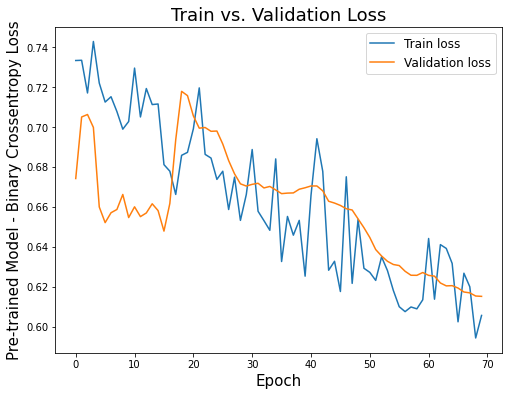

In [ ]:
epochs = [i for i in range(len(info3.history['accuracy']))]
plt.figure(figsize=(8,6))
plt.plot(epochs, info3.history['loss'], label="Train loss")
plt.plot(epochs, info3.history['val_loss'], label="Validation loss")
plt.legend(fontsize=12)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Pre-trained Model - Binary Crossentropy Loss", fontsize=15)
plt.title("Train vs. Validation Loss", fontsize=18)
plt.savefig(PROJECT_DIR + 'results/Pretrained_binary')

if shuffled:
  LOSS_SAVE_DIR = PROJECT_DIR + 'results/shuffled/' + image_size + '_incv3_fine_tune__loss'
else:
  LOSS_SAVE_DIR = PROJECT_DIR + 'results/' + image_size + '_70c_incv3_fine_tune__loss'

plt.savefig(LOSS_SAVE_DIR)


In [ ]:
from keras.models import load_model
fresh_model = load_model(MODEL_SAVE_DIR)

In [ ]:
train_scores = fresh_model.evaluate(X_train, y_train, verbose = 0) 

print("===== Train Set Results =====\n")
for metric,val in zip(fresh_model.metrics_names, train_scores):
  print("%12s: %.3f" % (metric, val))

===== Train Set Results =====

        loss: 0.560
    accuracy: 0.816
      auc_25: 0.918
precision_25: 0.798
   recall_25: 0.816


In [ ]:
val_scores = fresh_model.evaluate(X_val, y_val, verbose = 0) 

print("===== Val Set Results =====\n")
for metric,val in zip(fresh_model.metrics_names, val_scores):
  print("%12s: %.3f" % (metric, val))

===== Val Set Results =====

        loss: 0.615
    accuracy: 0.660
      auc_25: 0.699
precision_25: 0.697
   recall_25: 0.742


In [ ]:
test_scores = fresh_model.evaluate(X_test, y_test, verbose = 0) 

print("===== Test Set Results =====\n")
for metric,val in zip(fresh_model.metrics_names, test_scores):
  print("%12s: %.3f" % (metric, val))

===== Test Set Results =====

        loss: 0.704
    accuracy: 0.394
      auc_25: 0.477
precision_25: 0.333
   recall_25: 0.429


# Binary Classification w/ Team-level Cross Validation

## Prep folds for team-level cross validation

In [ ]:
# Define fold names
train_folds = []
test_folds = []
set_type = "test"
for j in range(1,num_folds+1): 
    col_name = "Fold" + str(j) + "_" + set_type
    test_folds.append(col_name)
    set_type = "train"  
    col_name = "Fold" + str(j) + "_" + set_type
    train_folds.append(col_name)
    set_type = "test"

folds_dict_list = []

# Split teams into 5 groups
teams = pd.unique(outcome_df.GROUPID)

# For every iteration
for i in range(1,num_iters+1):
    print("Iteration: ", i)
    teams = shuffle(teams, random_state=i)
    groups = np.array_split(teams, num_folds)
    
    # Define groups for each fold
    fold_groups = {}
    for j, (train_fold, test_fold) in enumerate(zip(train_folds, test_folds)):
        # make the current group the test group
        fold_groups[test_fold] = groups[j]
        # make all other groups the train group
        train_group = groups[:j] + groups[j+1:]
        train_group = [team for group in train_group for team in group]
        fold_groups[train_fold] = train_group
        
    ## Confirm that for each fold, there is no team overlap bewteen train and test set
    for j in range(1,num_folds+1):
        assert set(fold_groups['Fold'+str(j)+'_test']).isdisjoint(set(fold_groups['Fold'+str(j)+'_train'])), "There is overlap in train and test set " + str(j)
    
    print("* No team overlap *")

      
    # Add fold groups to dictionary
    folds_dict_list.append(fold_groups)
    

# Informational
print("\nNumber of iterations: ", len(folds_dict_list))

print("\nIterating through folds_dict_list to check for overlap...")
for i,dicti in enumerate(folds_dict_list):
    for j in range(1,num_folds+1):
        assert set(dicti['Fold'+str(j)+'_test']).isdisjoint(set(dicti['Fold'+str(j)+'_train'])), "There is overlap in train and test set " + str(j)
    
print("* No team overlap *")  



Iteration:  1
* No team overlap *

Number of iterations:  1

Iterating through folds_dict_list to check for overlap...
* No team overlap *


## Prepare model

In [ ]:
def get_binary_garcia_model():
  inputs = Input(shape=(imgsize[0], imgsize[1], 1))
  x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(inputs)
  x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.25)(x)
  x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
  x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.25)(x)
  x = layers.Dense(512, activation="relu")(x) 
  x = layers.Dropout(0.50)(x)
  x = layers.Flatten()(x)
  out = layers.Dense(1, activation="sigmoid")(x)   # change output layer to 1 and activation to sigmoid


  bc = tf.keras.losses.BinaryCrossentropy()        # change loss to binary
  lr = 0.00001 # paper used 0.001
  eps = 1e-08  # paper used 1e-08, but keras default is 1e-07
  adam = keras.optimizers.Adam(learning_rate=lr, epsilon=eps)
  auc = tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        from_logits=False
  )
  prec = tf.keras.metrics.Precision()
  rec = tf.keras.metrics.Recall()


  model_binary = Model(inputs=inputs, outputs=out)
  model_binary.compile(
    optimizer=adam,
    loss=bc, 
    metrics=['accuracy', auc, prec, rec],
  )

  return model_binary


In [ ]:
# Garcia-Ceja paper feeds CNN images with dims 100 x 100 x 4 (width x height x channels)
# Labels are one hot encoded

model_binary = get_binary_garcia_model()

model_binary.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 98, 98, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 96, 96, 16)        160       
                                                                 
 conv2d_25 (Conv2D)          (None, 94, 94, 16)        2320      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 47, 47, 16)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 45, 45, 32)        4640      
                                                          

## Run team-level cross validation

Iteration:  1
	Fold:  1
\m FOLD DATA INFO: 
	recurrence_plot_list: (27, 98, 98, 1)
	Binary label counts:  {1: 17, 0: 10}
\m FOLD DATA INFO: 
	recurrence_plot_list: (244, 98, 98, 1)
	Binary label counts:  {1: 115, 0: 129}
Epoch 1/20
8/8 [==============================] - 3s 29ms/step - loss: 5.1131 - accuracy: 0.5697 - auc_24: 0.5329 - precision_24: 0.5455 - recall_24: 0.5217
Epoch 2/20
8/8 [==============================] - 0s 26ms/step - loss: 5.2844 - accuracy: 0.5205 - auc_24: 0.5165 - precision_24: 0.4914 - recall_24: 0.4957
Epoch 3/20
8/8 [==============================] - 0s 23ms/step - loss: 4.7819 - accuracy: 0.5164 - auc_24: 0.5072 - precision_24: 0.4870 - recall_24: 0.4870
Epoch 4/20
8/8 [==============================] - 0s 19ms/step - loss: 5.6968 - accuracy: 0.4918 - auc_24: 0.4793 - precision_24: 0.4651 - recall_24: 0.5217
Epoch 5/20
8/8 [==============================] - 0s 19ms/step - loss: 5.6587 - accuracy: 0.4672 - auc_24: 0.4395 - precision_24: 0.4312 - recall_24: 0

,iteration,accuracy,auroc,precision,recall
0,1,0.549815,0.61767,0.52381,0.833333


Averages: 
      AUROC: 0.62
  Precision: 0.52
     Recall: 0.83
   Accuracy: 0.55
Med AUROC: 0.62


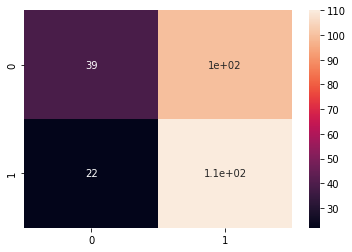

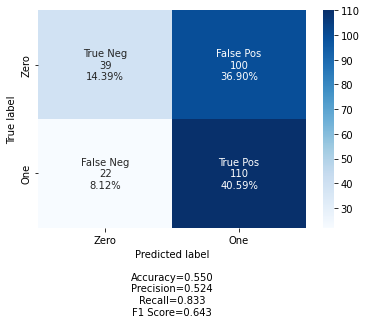

In [ ]:
# Store metrics for all iterations
aurocs = []
precision = []
recall = []
accuracy = []

all_y_test_task_score = [[] for i in range(num_iters)]
predictions_task_score = [[] for i in range(num_iters)]
predict_proba_task_score = [[] for i in range(num_iters)]

# For each iteration 
for i in range(num_iters):
    print("Iteration: ", i+1)
    
    # Lists for cumulative predictions for iteration
    all_y_test = []
    predictions = []
    predict_proba = []
    
    # Get fold groups
    fold_groups = folds_dict_list[i]
    
    # For each fold
    for j, (test_fold, train_fold) in enumerate(zip(test_folds, train_folds)):
        print("\tFold: ", j+1)
        # Get data for teams in test set
        [plot_list, labels, binary_labels] = get_fold_data(fold_groups[test_fold], incv3=False)
        X_test = plot_list
        y_test = binary_labels
        all_y_test.extend(y_test.tolist())
        
        # Get data for teams in train set
        [plot_list, labels, binary_labels] = get_fold_data(fold_groups[train_fold], incv3=False)
        X_train = plot_list
        y_train = binary_labels

        # Train model
        model_binary = get_binary_garcia_model()
        # model_binary.summary()
        info_bin_cv = model_binary.fit(x=X_train, y=y_train, epochs=20)

        # Test model: https://androidkt.com/get-class-labels-from-predict-method-in-keras/
        y_pp = model_binary.predict(X_test)
        y_pred = np.where(y_pp > threshold, 1, 0)

        predict_proba.extend(y_pp.tolist())
        predictions.extend(y_pred.tolist())

    # ----- END OF FOLDS

    all_y_test = np.array(all_y_test)
    all_y_test_task_score[i] = all_y_test
    
    predictions_task_score[i] = predictions
    predict_proba_task_score[i] = predict_proba
    
    
    # Get metrics of iteration
    auroc = roc_auc_score(all_y_test, predict_proba)
    prec = precision_score(all_y_test, predictions)
    rec = recall_score(all_y_test, predictions)
    acc = accuracy_score(all_y_test, predictions)
    
    aurocs.append(auroc)
    precision.append(prec)
    recall.append(rec)
    accuracy.append(acc)

     # Save actual labels and predictions for iteration
    dfTruevPred = pd.DataFrame({'actual': all_y_test, 'predict_proba': predict_proba, 'prediction': predictions})

    # FOR PLOTTING ACTUAL vs. PREDICTED: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea   
    cf_matrix = confusion_matrix(all_y_test, predictions)
    sns.heatmap(cf_matrix, annot=True)
    # END PLOTTING
        
    if shuffled:
      ACTvPRED_SAVE_DIR = PROJECT_DIR + "results/shuffled/cross_val/" + image_size + "_TaskScore_True_vs_Pred_SHUFF_" + str(i+1) + ".csv"
    else:
      ACTvPRED_SAVE_DIR = PROJECT_DIR + "results/cross_val/" + image_size + "_TaskScore_True_vs_Pred_" + str(i+1) + ".csv"
    dfTruevPred.to_csv(ACTvPRED_SAVE_DIR, index=False)    
    
# ----- END OF ITERATIONS

print("\n =========== ALL ITERATIONS RESULTS SUMMARY ===========")
dfMetrics = pd.DataFrame({'iteration': [i for i in range(1,num_iters+1)], 'accuracy': acc, \
                          'auroc': aurocs, 'precision': precision, 'recall': recall})

display(dfMetrics)

if shuffled:
  METRICS_SAVE_DIR = PROJECT_DIR + "results/shuffled/cross_val/" + image_size + "_TaskScore_Metrics_SHUFF.csv"
else:
  METRICS_SAVE_DIR = PROJECT_DIR + "results/cross_val/" + image_size + "_TaskScore_Metrics.csv"
dfMetrics.to_csv(METRICS_SAVE_DIR, index=False)   

print("Averages: ")
print("%12s %.2f" % ("AUROC:", np.mean(dfMetrics['auroc'])))
print("%12s %.2f" % ("Precision:", np.mean(dfMetrics['precision'])))
print("%12s %.2f" % ("Recall:", np.mean(dfMetrics['recall'])))
print("%12s %.2f" % ("Accuracy:", np.mean(dfMetrics['accuracy'])))


print("%6s %.2f" % ("Med AUROC:", np.median(dfMetrics['auroc'])))

# Get median iterations
med_auroc = np.median(aurocs)
med_auroc_idx = np.argsort(aurocs)[len(aurocs)//2]

# Plot confusion matrix of median iteration
cf_matrix = confusion_matrix(all_y_test_task_score[med_auroc_idx], predictions_task_score[med_auroc_idx])
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

# Now lets try regression
Ideas -- <br>
1) Use tanh activation function (-1, 1). Scale labels to between -1, 1. One issue is that our data is [0, 15].
  - we could scale to (-0.99999, 0.999999). 
  - we could add labels for -1 and 16, then scale to betwen (-1, 1) then remove these fake labels.

<br>
2) sigmoid output ^ same but (0, 1)



In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

# Split into train/test/val set
# Roughly val - 15%, test - 15%, train - 70%
X_train, X_test, y_train, y_test = train_test_split(recurrence_plot_list, labels, train_size=0.88)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.78)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("\n")
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("\n")
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)
print("\n")

print(y_test)

X_train:  (185, 359, 359, 1)
y_train:  (185,)


X_val:  (53, 359, 359, 1)
y_val:  (53,)


X_test:  (33, 359, 359, 1)
y_test:  (33,)


[ 6.  3.  6.  2.  7.  1.  4.  1.  5.  1.  1.  2.  3.  9.  6. 10.  0.  0.
  1. 11.  0.  1.  6.  1.  6.  3.  4.  2.  3.  2.  7.  4.  2.]


In [ ]:
# Garcia-Ceja paper feeds CNN images with dims 100 x 100 x 4 (width x height x channels)
# Labels are one hot encoded

inputs = Input(shape=(imgsize[0], imgsize[1], 1))
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(inputs)
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(512, activation="relu")(x) 
x = layers.Dropout(0.50)(x)
x = layers.Flatten()(x)
out = layers.Dense(1, activation="linear")(x) 

regression_model = Model(inputs=inputs, outputs=out)
regression_model.compile(
  optimizer = "adam",
  loss= "mse", #tf.keras.losses.MeanSquaredError(),  
  metrics=['accuracy'],
)

regression_model.summary()

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#Scale y train data from [0, 15] to (-1, 1) for training the neural network

scaler = MinMaxScaler(feature_range=(-1, 1))
scale_data = np.array([i for i in range(-1, 17)]).reshape(-1, 1)
scaler.fit(scale_data)

y_train_scaled = scaler.transform(y_train.reshape(-1, 1))
y_val_scaled = scaler.transform(y_val.reshape(-1, 1)) 

# #scale to our target range [0, 15]
# scaled_predictions = scaler.inverse_transform(test_predictions) #/6 * 15

# # round to nearest int
# final_pred = np.array([round(i) for i in scaled_predictions])

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10)
mcp_save = ModelCheckpoint('drive/MyDrive/data/results/.regression_best_weights.hdf5', save_best_only=True, monitor='val_loss', mode='min')

info_regression = regression_model.fit(x=X_train, y=y_train, epochs=50, verbose=True, validation_data=(X_val, y_val), callbacks=[mcp_save])

In [ ]:
epochs = [i for i in range(len(info_regression.history['accuracy']))]
plt.figure(figsize=(8,6))
plt.plot(epochs, info_regression.history['loss'], label="Train loss")
plt.plot(epochs, info_regression.history['val_loss'], label="Validation loss")
plt.legend(fontsize=12)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("MSE Loss", fontsize=15)
plt.title("Loss for Tanh, 16 nodes in output", fontsize=18)
#plt.savefig('drive/MyDrive/data/results/Softmax_categorical')

In [ ]:
regression_model.load_weights(filepath = 'drive/MyDrive/data/results/.regression_best_weights.hdf5')

In [ ]:
# now calculate the actual accuracy
test_predictions = regression_model.predict(X_test)
train_predictions = regression_model.predict(X_train)
val_predictions = regression_model.predict(X_val)

In [ ]:
final_pred = enc.inverse_transform(test_predictions).squeeze()
final_train_pred = enc.inverse_transform(train_predictions).squeeze()
final_val_pred = enc.inverse_transform(val_predictions).squeeze()

In [ ]:
test_acc = accuracy(final_pred, y_test)
train_acc = accuracy(final_train_pred, y_train)
val_acc = accuracy(final_val_pred, y_val)
print("Classification with tanh")
print("----Results----")
print(f"Size of train set: {y_train.shape[0]}")
print(f"Train acc: {train_acc}")
print(f"----\nSize of validation set: {y_val.shape[0]}")
print(f"Validation acc: {val_acc}")
print(f"----\nSize of test set: {y_test.shape[0]}")
print(f"Test acc: {test_acc}")

In [ ]:
y_train